In [152]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns




from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline


from tqdm import tqdm
import time

# *Methods* 

In [25]:
#method to compute the confusion matrix 
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


#method to plot the matrix 
def plot_confusion_matrix(confusion_matrix):
    
    [[TP, FP],[FN, TN]] = confusion_matrix  #define the matrix
    
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]]) #label the boxes of the confusion matrix
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative'])  
    
    return sns.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='') #plot heatmap


#compute the score 
def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    #calculate the precision  (what fraction of positive predictions is true)
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    #calculate the recall (what fraction of positive example are recognized as such)
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan
    
    #harmonic mean of the recall and precision

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [26]:
def accuracy (matrix_confusion) : 
  
 #recover the different performance of the classifier 
    [t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(matrix_confusion)
    
 #print them 

    print("The accuracy of this model is {0:1.3f}".format(accuracy))
    print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
    print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))
    

In [164]:
def features_imp (train_f, params) :
    
    tmp = []
    for name, value in zip(train_f, params):
        tmp.append({"name": name, "value": value}) #concatenate value and names of the features

    features_coef = pd.DataFrame(tmp).sort_values("value")
    features_coef.head() # visualise first coefficient
    
    plt.subplots(figsize=(5,20))
 
    plt.barh(features_coef.name, features_coef.value, alpha=0.6) #plot features_names and their relative importance into the model

## *Data preparation*

To perform our classification will test if reduced diéensionality of our features is preferable or not. To dos som we will prepare two set of data : one standarized and one reduced with PCA. 

In [28]:
data_original = pd.read_csv("data/one_hot.bz2", compression = 'bz2') #load the data one hot encoding

In [29]:
data_features = data_original.copy()
data_features.head(3)

,date_of_birth,climate,['association football player'],['politician'],['actor'],['writer'],['researcher'],['painter'],['visual artist'],['journalist'],...,"['transgender female', 'male']","['transgender female', 'female']","['intersex', 'non-binary']",['genderqueer'],['cisgender female'],"['intersex', 'female']","['male', 'transgender female']","['female', 'non-binary']",['transgender person'],['cisgender male']
0,1952,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1946,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1945,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*preparation of our features*

In [30]:
#method to split our data
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [111]:
[train, test] = split_set(data_features) #split data into train and test set 

*unmodified features*

In [113]:
#separate features from label

train_label=train.climate
train_features = train.drop('climate', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test.climate
test_features = test.drop('climate', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 2315767
Length of the test dataset : 579269


*standarized features*

In [154]:
#scale our dataset : Standardize features by removing the mean and scaling to unit variance.
train_scaled = pd.DataFrame(preprocessing.scale(train_features),columns =train_features.columns) 
test_scaled = pd.DataFrame(preprocessing.scale(test_features),columns =test_features.columns) 

*PCA reduction for selected n important features*

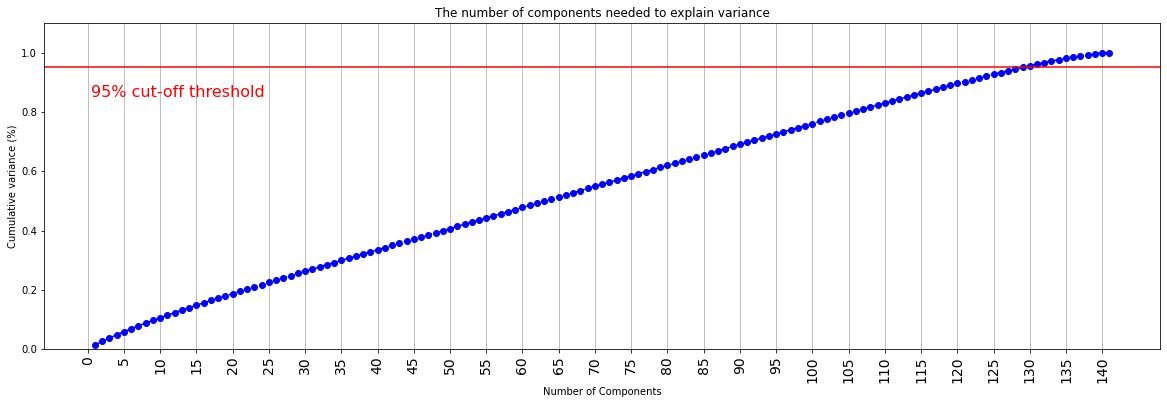

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.014482,0.014482
1,0.026342,0.011860
2,0.037597,0.011255
3,0.048555,0.010958
4,0.059153,0.010598
5,0.069280,0.010128
6,0.079061,0.009781
7,0.088090,0.009029
8,0.097016,0.008926
9,0.105886,0.008870


In [151]:
pca_test = PCA().fit(train_scaled) #PCA on train set



#plot parameters
plt.rcParams["figure.figsize"] = (20,6)
fig, ax = plt.subplots()
xi = np.arange(1, 142, step=1) #components number
y = np.cumsum(pca_test.explained_variance_ratio_) #variance explained by the n component

#plot estethic

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 142, step=5), rotation=90, fontsize=14) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
#Creation of Dataframe containing the major components
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

Now we know tha 

In [150]:
pca = PCA(n_components = 130)
pca.fit(train_scaled)
X_train_scaled_pca = pca.transform(train_scaled)
X_test_scaled_pca = pca.transform(test_scaled)

## *Fit To “Baseline” Logistic classification with stochastic gradient*

Now we create a “baseline” for logistic classifier with stochastic gradient. This model uses all of the predicting features and of the default settings defined in the Scikit-learn Random Forest Classifier documentation. First, we instantiate the model and fit the scaled data to it. We can measure the accuracy of the model on our training data.

The accuracy of this model is 0.049
For the positive case, the precision is 0.049, the recall is 1.000 and the F1 score is 0.094
For the negative case, the precision is nan, the recall is 0.000 and the F1 score is nan


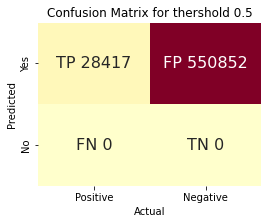

In [158]:
sgdc=SGDClassifier(loss='log')
sgdc.fit(train_scaled, train_label)

prediction_proba=sgdc.predict_proba(test_features) 
    
#construct the confusion matrix
confusion_matrix_05_baseline = compute_confusion_matrix(test_label, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_baseline)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_baseline)

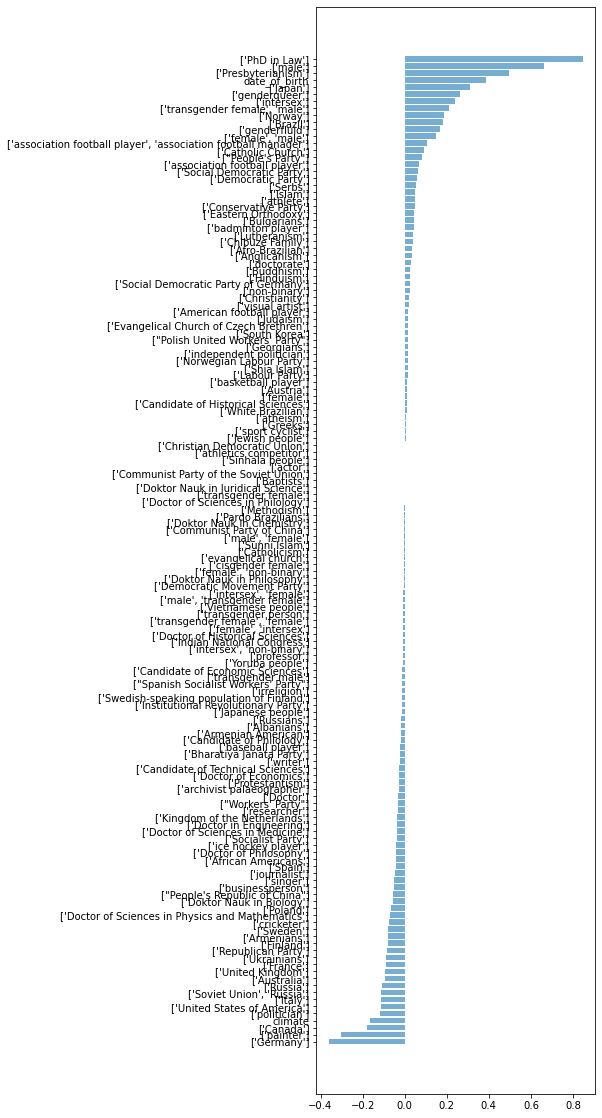

In [165]:
features_imp(data_features.columns, sgdc.coef_[0]) #represensation of features according to their importance

## *Logistic Regression with sthocasthic gradient*

SGD Classifier implements regularised linear models with Stochastic Gradient Descent which only consider 1 random point while changing weights unlike gradient descent which considers the whole training data. As such stochastic gradient descent is much faster than gradient descent when dealing with large data sets, which is our case.
Howeve, by default the SGD Classifier does not perform as well as the Logistic Regression, but with  some hyper parameter tuning we can make it as good.

*With PCA*

In [168]:
#declaration of a pipe flow
pipe = Pipeline([('std_slc', StandardScaler()),
                ('pca', PCA()),
                ('logistic',SGDClassifier())])
    
    
# pipe flow is :
# PCA(Dimension reduction to two) -> Scaling the data -> SDGClassifier


#different parameters for hypertunning
n_components = [10]
penalty = ['l1', 'l2'] 
alpha = [1e-3, 1e-2, 1e-1, 1e0, 10]
loss=['log']
max_iter=[10000, 100000]
n_jobs = [-1]



# make lists of different parameters to check
param_grid = dict(pca__n_components=n_components, logistic__penalty=penalty, 
logistic__alpha=alpha,logistic__loss=loss,logistic__max_iter=max_iter, logistic__n_jobs=n_jobs) 


#loop to follow the progress
for i in tqdm(range(20), desc = 'tqdm() Progress Bar'):
    time.sleep(0.5) 
    
    # initialize
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 3) 
    
    #fit
    grid_result = grid.fit(train_features, train_label) 
    
    #print score and params of the best model
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

tqdm() Progress Bar:   0%|                               | 0/20 [00:00<?, ?it/s]

Fitting 2 folds for each of 24 candidates, totalling 48 fits


tqdm() Progress Bar:   5%|█                   | 1/20 [12:27<3:56:39, 747.35s/it]

Best Score:  0.7234409576797437
Best Params:  {'logistic__alpha': 0.001, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2', 'pca__n_components': 10}
Fitting 2 folds for each of 24 candidates, totalling 48 fits


tqdm() Progress Bar:   5%|█                   | 1/20 [13:31<4:16:53, 811.26s/it]


KeyboardInterrupt: 

In [ ]:
pipe = Pipeline([('std_slc', StandardScaler()),
                ('pca', PCA()),
                ('logistic',LogisticRegression())])
    
    
# pipe flow is :
# PCA(Dimension reduction to two) -> Scaling the data -> SDGClassifier


#different parameters for hypertunning
n_component =[2]
C = [0.01, 0.1, 1, 10, 100, 1000, 10000] 
max_iter=[10000, 100000]


# make lists of different parameters to check
param_grid = dict(pca__n_components=n_components, logistic__C=C, logistic__max_iter=max_iter) 


#loop to follow the progress
for i in tqdm(range(20), desc = 'tqdm() Progress Bar'):
    time.sleep(0.5) 
    
    # initialize
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 3) 
    
    #fit
    grid_result = grid.fit(train_features, train_label) 
    
    #print score and params of the best model
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

tqdm() Progress Bar:   0%|                               | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 14 candidates, totalling 42 fits


*without PCA* 

In [176]:
#declaration of a pipe flow
pipe = Pipeline([('std_slc', StandardScaler()),
                 ('logistic',SGDClassifier())])
    
    
# pipe flow is :
# PCA(Dimension reduction to two) -> Scaling the data -> SDGClassifier


#different parameters for hypertunning

 
penalty = ['l1', 'l2'] 
alpha = [1e-3, 1e-2, 1e-1, 1e0, 10]
loss=['log']
max_iter=[10000, 100000]
n_jobs = [-1]



# make lists of different parameters to check
param_grid = dict(logistic__penalty=penalty, 
logistic__alpha=alpha,logistic__loss=loss,logistic__max_iter=max_iter, logistic__n_jobs=n_jobs) 


#loop to follow the progress
for i in tqdm(range(20), desc = 'tqdm() Progress Bar'):
    time.sleep(0.5) 
    
    # initialize
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 3) 
    
    #fit
    grid_result = grid.fit(train_features, train_label) 
    
    #print score and params of the best model
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

tqdm() Progress Bar:   0%|                               | 0/20 [00:00<?, ?it/s]

Fitting 2 folds for each of 24 candidates, totalling 48 fits


tqdm() Progress Bar:   5%|█                   | 1/20 [15:37<4:56:47, 937.25s/it]

Best Score:  0.7924793358254423
Best Params:  {'logistic__alpha': 0.001, 'logistic__loss': 'log', 'logistic__max_iter': 100000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 24 candidates, totalling 48 fits


tqdm() Progress Bar:   5%|█                   | 1/20 [16:02<5:04:46, 962.45s/it]


KeyboardInterrupt: 

## *Let's see the result !*

In [ ]:
prediction_proba=clf_sdg.predict_proba(test_features) 
confusion_matrix_05_sdg = compute_confusion_matrix(test_label, prediction_proba, 0.5)
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05_sdg)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    

accuracy (confusion_matrix_05_sdg)
    
features_imp(clf_sdg.feature_names_in_, clf_sdg.coef_[0])
    

#### 2.2 - Remove features vs not 

#### 2.2 - classification per caracheristic 

In [178]:
occupation_train, occupation_test = [train_features.iloc[:, 1:21], test_features.iloc[:, 1:21]]
gender_train, gender_test = [train_features.iloc[:, 121:141], test_features.iloc[:, 121:141]]
nationality_train, nationality_test =[train_features.iloc[:, 61:81], test_features.iloc[:, 61:81]]

In [181]:
dico={'occupation' : occupation_train, 'gender' : gender_train, 'nationality ':nationality_train}

In [173]:
#scale our dataset : Standardize features by removing the mean and scaling to unit variance.
train_scaled_occ = pd.DataFrame(preprocessing.scale(occupation_train),columns =occupation_train.columns) 
test_scaled_occ = pd.DataFrame(preprocessing.scale(occupation_test),columns =occupation_test.columns) 
train_scaled_gender = pd.DataFrame(preprocessing.scale(gender_train),columns =gender_train.columns) 
test_scaled_gender = pd.DataFrame(preprocessing.scale(gender_test),columns =gender_test.columns) 


In [183]:
#declaration of a pipe flow
pipe = Pipeline([ ('std_slc', StandardScaler()), ('logistic',SGDClassifier())])
# pipe flow is :
# Scaling the data -> DecisionTreeClassification
    

#different parameters for hypertunning
penalty = ['l1', 'l2'] 
alpha = [1e-3, 1e-2, 1e-1, 1e0, 10]
loss=['log']
max_iter=[10000, 100000]
n_jobs = [-1]



# make lists of different parameters to check
param_grid = dict(logistic__penalty=penalty, 
logistic__alpha=alpha,logistic__loss=loss,logistic__max_iter=max_iter, logistic__n_jobs=n_jobs) 



#loop to follow the progress
for i in tqdm(range(20), desc = 'tqdm() Progress Bar'):
    time.sleep(0.5)
    
    # initialize
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 3) 
    
    #fit
    for name, data in dico.items() :
        
        grid_result = grid.fit(data, train_label)  
        print(f'Best Score for {name}: ', grid_result.best_score_) 
        print(f'Best Params for {name}: ', grid_result.best_params_) 

tqdm() Progress Bar:   0%|                               | 0/20 [00:00<?, ?it/s]

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Score for occupation:  0.5835422848577595
Best Params for occupation:  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Score for gender:  0.5403412632870032
Best Params for gender:  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


tqdm() Progress Bar:   5%|█▏                     | 1/20 [00:51<16:20, 51.61s/it]

Best Score for nationality :  0.5139009973846329
Best Params for nationality :  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Score for occupation:  0.583632165562991
Best Params for occupation:  {'logistic__alpha': 0.001, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Score for gender:  0.5403161996500359
Best Params for gender:  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


tqdm() Progress Bar:  10%|██▎                    | 2/20 [01:43<15:30, 51.70s/it]

Best Score for nationality :  0.5139006728925862
Best Params for nationality :  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Score for occupation:  0.583683997765462
Best Params for occupation:  {'logistic__alpha': 0.001, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Score for gender:  0.5403364131687657
Best Params for gender:  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


tqdm() Progress Bar:  15%|███▍                   | 3/20 [02:49<16:32, 58.39s/it]

Best Score for nationality :  0.5139003664879898
Best Params for nationality :  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Score for occupation:  0.5835522748789033
Best Params for occupation:  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Score for gender:  0.5403246712312184
Best Params for gender:  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


tqdm() Progress Bar:  20%|████▌                  | 4/20 [03:46<15:21, 57.60s/it]

Best Score for nationality :  0.5139008812461597
Best Params for nationality :  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Score for occupation:  0.5835600225432398
Best Params for occupation:  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Score for gender:  0.5403837802475512
Best Params for gender:  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


tqdm() Progress Bar:  25%|█████▊                 | 5/20 [04:35<13:37, 54.53s/it]

Best Score for nationality :  0.5139009590355801
Best Params for nationality :  {'logistic__alpha': 0.01, 'logistic__loss': 'log', 'logistic__max_iter': 10000, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


tqdm() Progress Bar:  25%|█████▊                 | 5/20 [04:45<14:15, 57.05s/it]


KeyboardInterrupt: 

## *Let's see the result !*

In [134]:
clf = SGDClassifier(alpha = 0.1, loss='log', max_iter=10000,  penalty = 'l2')
clf.fit(train_scaled_occ, train_label)

prediction_proba=clf.predict_proba(test_scaled_occ) 
confusion_matrix_05_sdg = compute_confusion_matrix(test_label, prediction_proba, 0.5)
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05_sdg)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    

accuracy (confusion_matrix_05_sdg)
    
features_imp(clf_sdg.feature_names_in_, clf_sdg.coef_[0])

/Users/yousraferiel/opt/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- ['Catholic Church']

  warnings.warn(message, FutureWarning)


ValueError: X has 20 features, but SGDClassifier is expecting 21 features as input.